In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import datetime
from pandas_datareader import data
import matplotlib.pyplot as plt
import statsmodels.tsa.filters.hp_filter as hp_filter

In [2]:
#Data import and sorting
start = datetime.datetime(1950,1,1)
u_rate = data.DataReader(["UNRATE"], "fred", start)
u_rate_quarterly_ma = 1/3*(u_rate + u_rate.shift(-1) + u_rate.shift(-2))
u_rate_quarterly_ma['DATES'] = u_rate_quarterly_ma.index
prod = data.DataReader(["ULQELP01USQ661S"], "fred", start) 
prod['DATES'] = prod.index

sep_prob = pd.read_table("data/sep_prob.txt", sep=",")
sep_prob.columns = ['Time', 'Value']

sep_prob['Time'] = sep_prob['Time'].astype(str)
sep_prob['Year'] = sep_prob['Time'].str[:4]
sep_prob['Year'] =  sep_prob['Year'].astype(int)
sep_prob['Quarter'] = sep_prob['Time'].str[4:]
sep_prob['Quarter'] =  sep_prob['Quarter'].astype(float)
sep_prob['Quarter'] = sep_prob['Quarter']*4 +1 
sep_prob['Quarter'] =  sep_prob['Quarter'].astype(int)

sep_prob['Date'] = pd.to_datetime(sep_prob.Year*10000 + (1+(sep_prob.Quarter-1)*3)*100 + 1, format='%Y%m%d')
sep_prob = sep_prob.set_index('Date', drop=False)
sep_prob.drop(['Time', 'Year', 'Quarter'], axis=1, inplace=True)
sep_prob.columns = ['sep_prob', 'DATES']


find_prob = pd.read_table("data/find_prob.txt", sep=",")
find_prob.columns = ['Time', 'Value']

find_prob['Time'] = find_prob['Time'].astype(str)
find_prob['Year'] = find_prob['Time'].str[:4]
find_prob['Year'] =  find_prob['Year'].astype(int)
find_prob['Quarter'] = find_prob['Time'].str[4:]
find_prob['Quarter'] =  find_prob['Quarter'].astype(float)
find_prob['Quarter'] = find_prob['Quarter']*4 +1 
find_prob['Quarter'] =  find_prob['Quarter'].astype(int)

find_prob['Date'] = pd.to_datetime(find_prob.Year*10000 + (1+(find_prob.Quarter-1)*3)*100 + 1, format='%Y%m%d')
find_prob = find_prob.set_index('Date', drop=False)
find_prob.drop(['Time', 'Year', 'Quarter'], axis=1, inplace=True)
find_prob.columns = ['find_prob', 'DATES']

vacancy_rate = pd.read_table("data/HWI_index_barnichon.txt", skiprows=7, header=None)
vacancy_rate.columns = ['Time', 'Value']

vacancy_rate['Time'] = vacancy_rate['Time'].astype(str)
vacancy_rate['Year'] = vacancy_rate['Time'].str[:4]
vacancy_rate['Year'] =  vacancy_rate['Year'].astype(int)
vacancy_rate['Month'] = vacancy_rate['Time'].str[5:]
vacancy_rate['Month'] =  vacancy_rate['Month'].astype(int)

vacancy_rate['Date'] = pd.to_datetime(vacancy_rate.Year*10000 + vacancy_rate.Month*100 + 1, format='%Y%m%d')
vacancy_rate = vacancy_rate.set_index('Date', drop=False)
vacancy_rate.drop(['Time', 'Year', 'Month', 'Date'], axis=1, inplace=True)
vacancy_rate.columns = ['Vrate']

vacancy_rate_quarterly_ma = 1/3*(vacancy_rate + vacancy_rate.shift(-1) + vacancy_rate.shift(-2))
vacancy_rate_quarterly_ma['DATES'] = vacancy_rate_quarterly_ma.index

In [4]:
df = prod.merge(u_rate_quarterly_ma, how = 'inner')
df = df.merge(vacancy_rate_quarterly_ma, how = 'inner')
df = df.merge(sep_prob, how = 'inner')
df = df.merge(find_prob, how = 'inner')
df.columns = ['Prod', 'Date', 'Urate', 'Vrate', 'Sprob', 'Fprob']
df.set_index(df['Date'], inplace=True)

#Transform rate to prob
df['Srate'] = - np.log(1-df['Sprob'])
df['Frate'] = - np.log(1-df['Fprob'])

#Compute Steady state unemployment state
df['Urate_ss'] = df['Srate']/(df['Srate'] + df['Frate'])

#Compute tightness
df['Tightness'] = df['Vrate']/df['Urate']
df['Tightness_index'] = df['Tightness']/df['Tightness'].iloc[-1]


#Detrend
df['Prod_cycle'], df['Prod_trend']= hp_filter.hpfilter(df['Prod'], 1600)
df['Tightness_cycle'], df['Tightness_trend']= hp_filter.hpfilter(df['Tightness_index'], 1600)
df['Urate_cycle'], df['Urate_trend']= hp_filter.hpfilter(df['Urate'], 1600)
df['Srate_cycle'], df['Srate_trend']= hp_filter.hpfilter(df['Srate'], 1600)

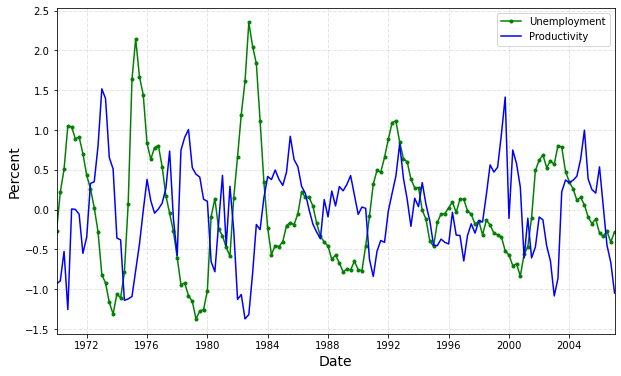

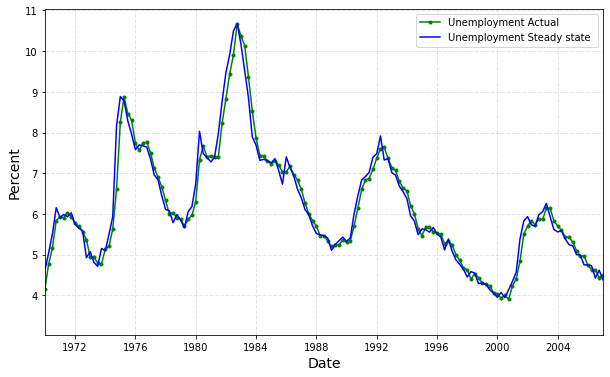

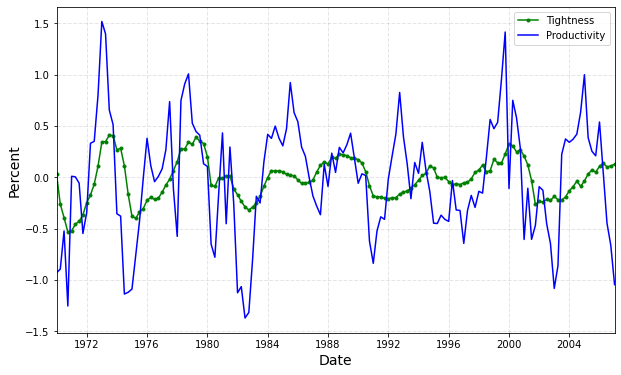

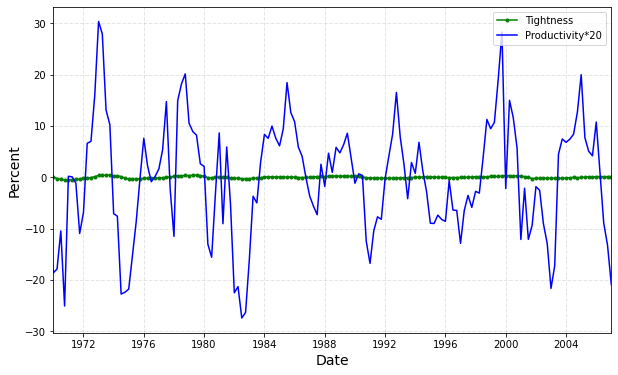

In [7]:
#Graphs
plt.rcParams['figure.figsize'] = 10, 6

fig, ax1 = plt.subplots()
ax1.plot(df['Date'], df['Urate_cycle'], 'g.-')
ax1.plot(df['Date'], df['Prod_cycle'], 'b-')
#ax1.plot(df['Date'], df['Srate_cycle']*100, 'r--')
ax1.set_xlim([datetime.date(1970, 1, 1), datetime.date(2007, 1, 1)])
ax1.legend(['Unemployment', 'Productivity', 'Separations'], loc=1)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Percent', fontsize=14)
ax1.grid(color='grey', linestyle='--', linewidth=1, alpha=0.2)
plt.savefig("../figures/prod_urate.pdf")
plt.show()

fig, ax2 = plt.subplots()
ax2.plot(df['Date'], df['Urate'], 'g.-')
ax2.plot(df['Date'], df['Urate_ss']*100, 'b-')
ax2.set_xlim([datetime.date(1970, 1, 1), datetime.date(2007, 1, 1)])
ax2.legend(['Unemployment Actual', 'Unemployment Steady state '], loc=1)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Percent', fontsize=14)
ax2.grid(color='grey', linestyle='--', linewidth=1, alpha=0.2)
plt.savefig("../figures/urate_ss.pdf")
plt.show()



fig, ax3 = plt.subplots()
ax3.plot(df['Date'], df['Tightness_cycle'], 'g.-')
ax3.plot(df['Date'], df['Prod_cycle'], 'b-')
ax3.set_xlim([datetime.date(1970, 1, 1), datetime.date(2007, 1, 1)])
ax3.legend(['Tightness', 'Productivity'], loc=1)
ax3.set_xlabel('Date', fontsize=14)
ax3.set_ylabel('Percent', fontsize=14)
ax3.grid(color='grey', linestyle='--', linewidth=1, alpha=0.2)
plt.savefig("../figures/prod_tight.pdf")
plt.show()


fig, ax3 = plt.subplots()
ax3.plot(df['Date'], df['Tightness_cycle'], 'g.-')
ax3.plot(df['Date'], df['Prod_cycle']*20, 'b-')
ax3.set_xlim([datetime.date(1970, 1, 1), datetime.date(2007, 1, 1)])
ax3.legend(['Tightness', 'Productivity*20'], loc=1)
ax3.set_xlabel('Date', fontsize=14)
ax3.set_ylabel('Percent', fontsize=14)
ax3.grid(color='grey', linestyle='--', linewidth=1, alpha=0.2)
plt.savefig("../figures/prod_tight_adj.pdf")
plt.show()